# [과제 2] 회귀분석
### - Ch 1, Ch 2를 토대로 자유롭게 회귀분석과 회귀진단을 진행해주세요.
### - 주석으로 설명 및 근거 자세하게 달아주시면 감사하겠습니다. :)

In [1]:
%matplotlib inline 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

# Data 

데이터 출처 : https://www.kaggle.com/avikasliwal/used-cars-price-prediction 

< y > 
* **Price** : The price of the used car in INR Lakhs.



< X > 
* Name : The brand and model of the car
* Location : The location in which the car is being sold or is available for purchase.
* Year : The year or edition of the model.
* Kilometers_Driven : The total kilometres driven in the car by the previous owner(s) in KM.
* Fuel_Type : The type of fuel used by the car. (Petrol, Diesel, Electric, CNG, LPG)
* Transmission : The type of transmission used by the car. (Automatic / Manual)
* Owner_Type : Whether the ownership is Firsthand, Second hand or other.
* Mileage : The standard mileage offered by the car company in kmpl or km/kg
* Engine : The displacement volume of the engine in CC.
* Power : The maximum power of the engine in bhp.
* Seats : The number of seats in the car.
* New_Price : The price of a new car of the same model.

In [2]:
# Load Data 
data = pd.read_csv("assignment2_data.csv")
data.drop(['Unnamed: 0'], axis=1, inplace=True) # 필요없는 열 삭제(의미 없는 인덱스를 가졌기 때문)
data.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [3]:
data.shape # 데이터 차원 확인, 6019개의 행과 13개의 변수를 가지고 있음.

(6019, 13)

# 데이터 탐색

전처리에 앞서 데이터를 어떻게 전처리해야할 지 그래프 등을 그려보며 데이터를 탐색한다.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   object 
 8   Engine             5983 non-null   object 
 9   Power              5983 non-null   object 
 10  Seats              5977 non-null   float64
 11  New_Price          824 non-null    object 
 12  Price              6019 non-null   float64
dtypes: float64(2), int64(2), object(9)
memory usage: 611.4+ KB


- Object 타입 변수들 : Name, Location, Fuel_Type, Transmission, Owner_Type, Mileage, Engine, Power, New_Price <br>
But, 이 중 
    - Mileage, Engine, Power는 단위가 포함되어 있기 때문에 Object Type으로 인식됨.
    - Seats, New_Price는 결측치가 있기 때문에 Object Type으로 인식됨.
- Numeric 타입 변수들 : Year, Kilometers_Driven, Seats, Price

In [5]:
pd.DataFrame(data.isna().sum(), columns={'NaN 개수'})

,NaN 개수
Name,0
Location,0
Year,0
Kilometers_Driven,0
Fuel_Type,0
Transmission,0
Owner_Type,0
Mileage,2
Engine,36
Power,36


In [6]:
pd.DataFrame(round(data.isna().sum()/len(data),4), columns={'NaN 비율'})

,NaN 비율
Name,0.0000
Location,0.0000
Year,0.0000
Kilometers_Driven,0.0000
Fuel_Type,0.0000
Transmission,0.0000
Owner_Type,0.0000
Mileage,0.0003
Engine,0.0060
Power,0.0060


- New_Price는 결측치 비율이 86.3%로 결측치가 매우 많은 변수.따라서 New_Price는 삭제한다.
- Mileage, Engine, Power, Seats는 각각 결측치 비율이 0.03,0.6,0.7%이므로 결측치 대체를 진행한다. 

### 범주형 변수 확인
불균형한 데이터가 있는지 확인

- Object 타입 변수들 : Name, Location, Fuel_Type, Transmission, Owner_Type

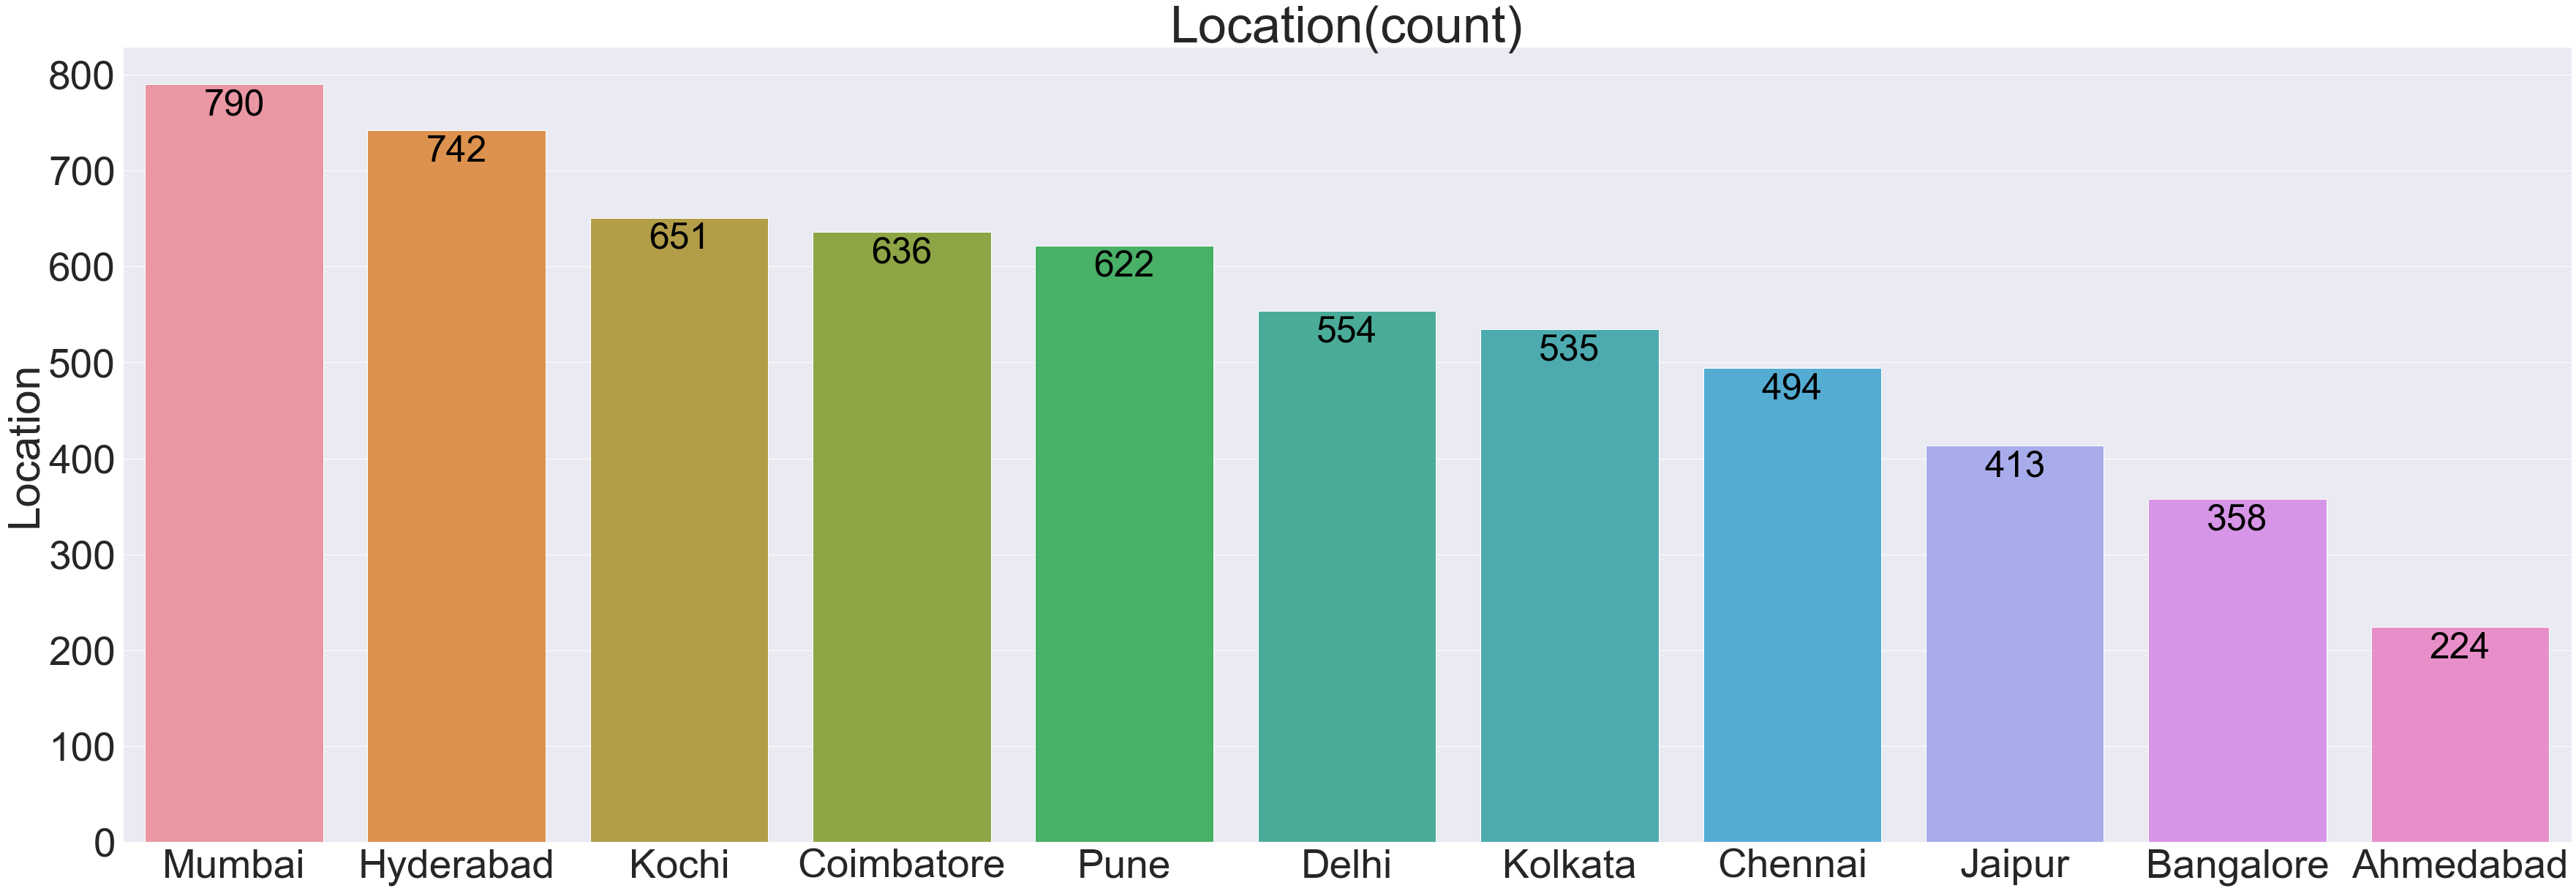

In [7]:
# Location
sns.set(font_scale = 5)
vc_tmp = pd.DataFrame(data['Location'].value_counts())
plt.figure(figsize=(60, 20), facecolor='white')
g = sns.barplot(x= vc_tmp.index, y=vc_tmp['Location'])
ax = g

# 각 범주별 데이터 개수 확인
for p in ax.patches: 
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width()/2., p.get_height() - 30), 
       ha='center', va='center', fontsize=50, color='black', xytext=(0, 10), 
       textcoords='offset points') 

plt.title("%s(count)"%'Location', fontsize=70)
plt.show()

데이터개수가 가장 많은 범주 Mumbal과 데이터개수가 가장 적은 범주 Ahmedabad의 데이터수는 약 3.5배 차이나지만, 크게 불균형한 것은 아님. <br>그러나 범주가 11개로 많은 편. 

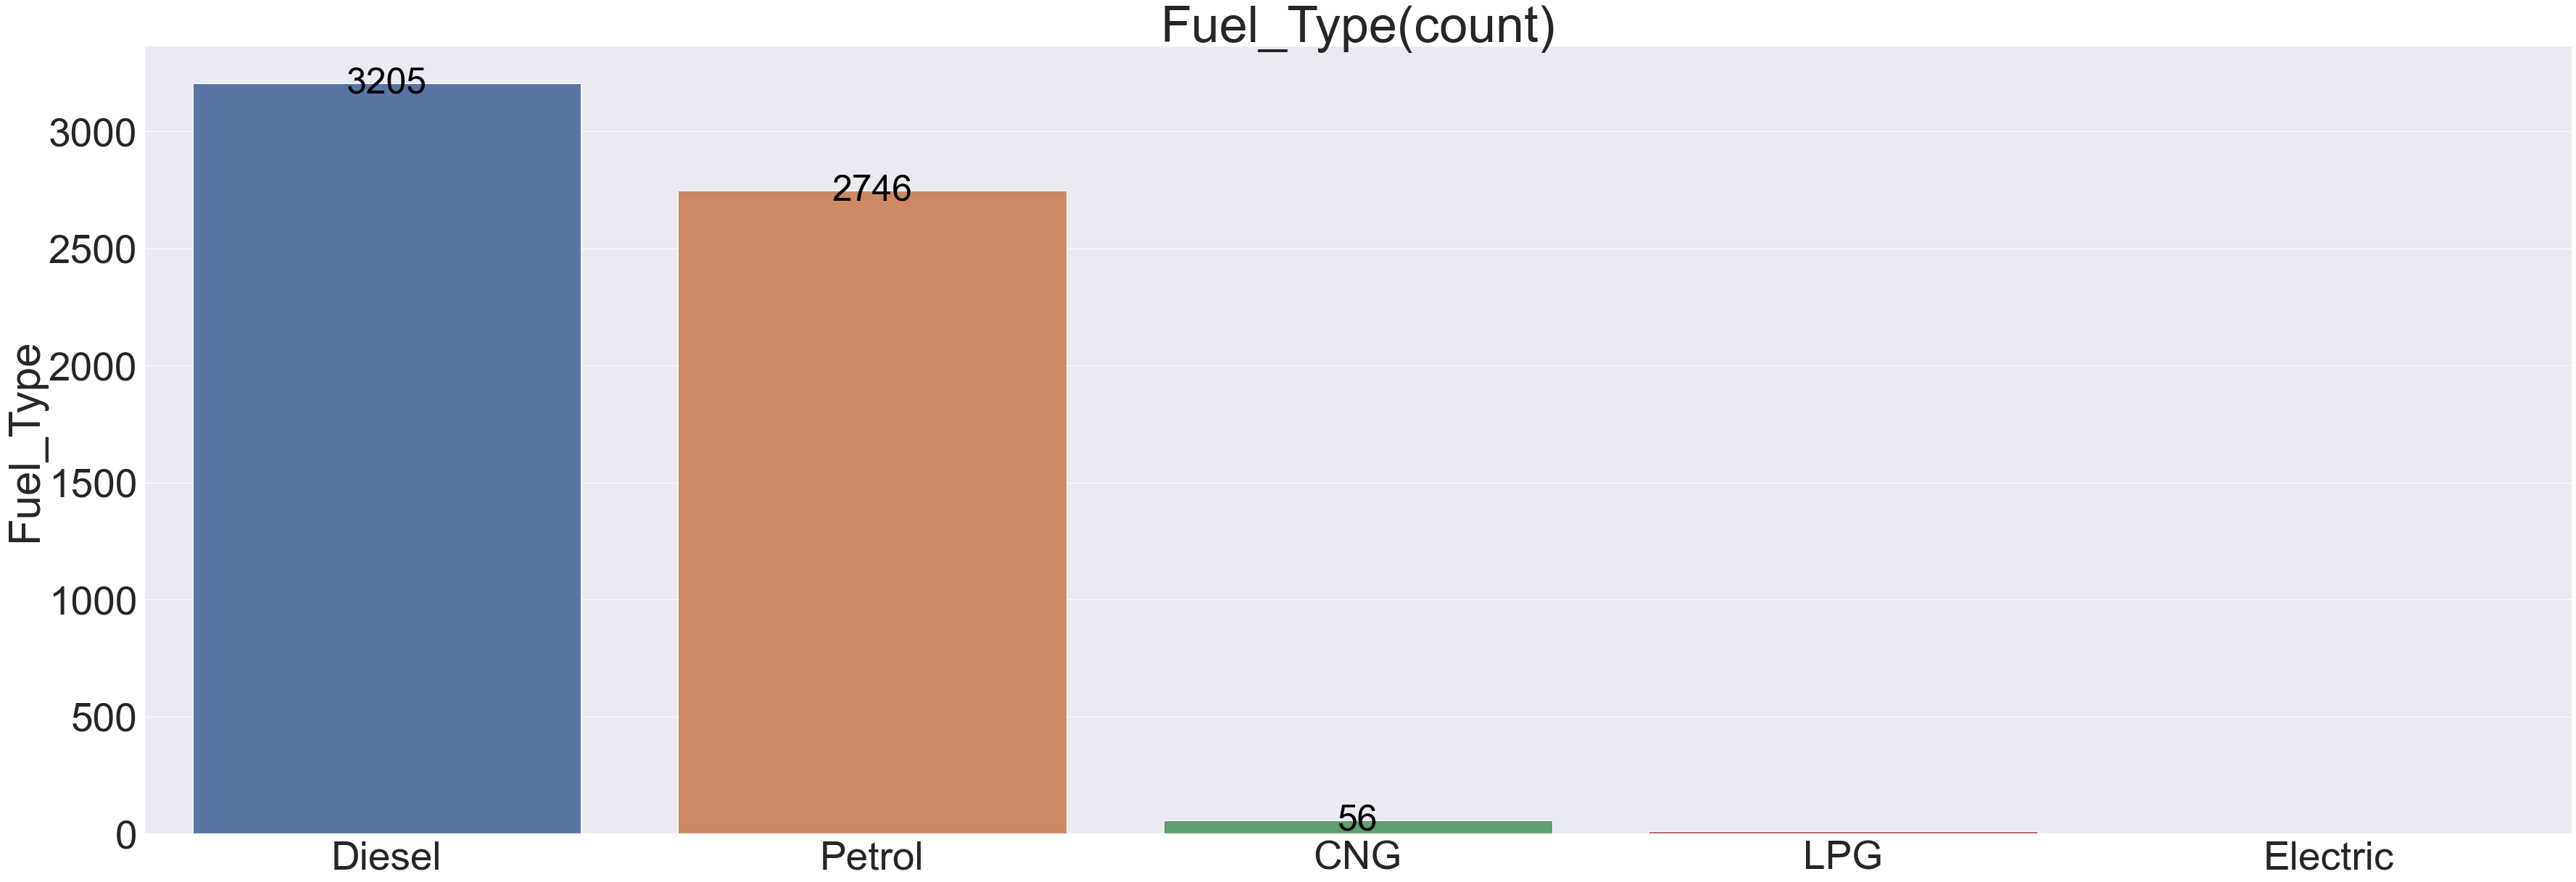

In [8]:
# Fuel_Type
sns.set(font_scale = 5)
vc_tmp = pd.DataFrame(data['Fuel_Type'].value_counts())
plt.figure(figsize=(60, 20), facecolor='white')
g = sns.barplot(x= vc_tmp.index, y=vc_tmp['Fuel_Type'])
ax = g

# 각 범주별 데이터 개수 확인
for p in ax.patches: 
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width()/2., p.get_height() - 30), 
       ha='center', va='center', fontsize=50, color='black', xytext=(0, 10), 
       textcoords='offset points') 

plt.title("%s(count)"%'Fuel_Type', fontsize=70)
plt.show()

Diesel과 Petrol이 대부분을 차지하고, CNG, LPG, Electric 범주에 속하는 데이터는 매우 적어 데이터 불균형이 있는 변수라고 판단하였다. <br>
따라서 전처리 단계에서 범주를 Diesel, Petrol, etc 로 재범주화 한다.

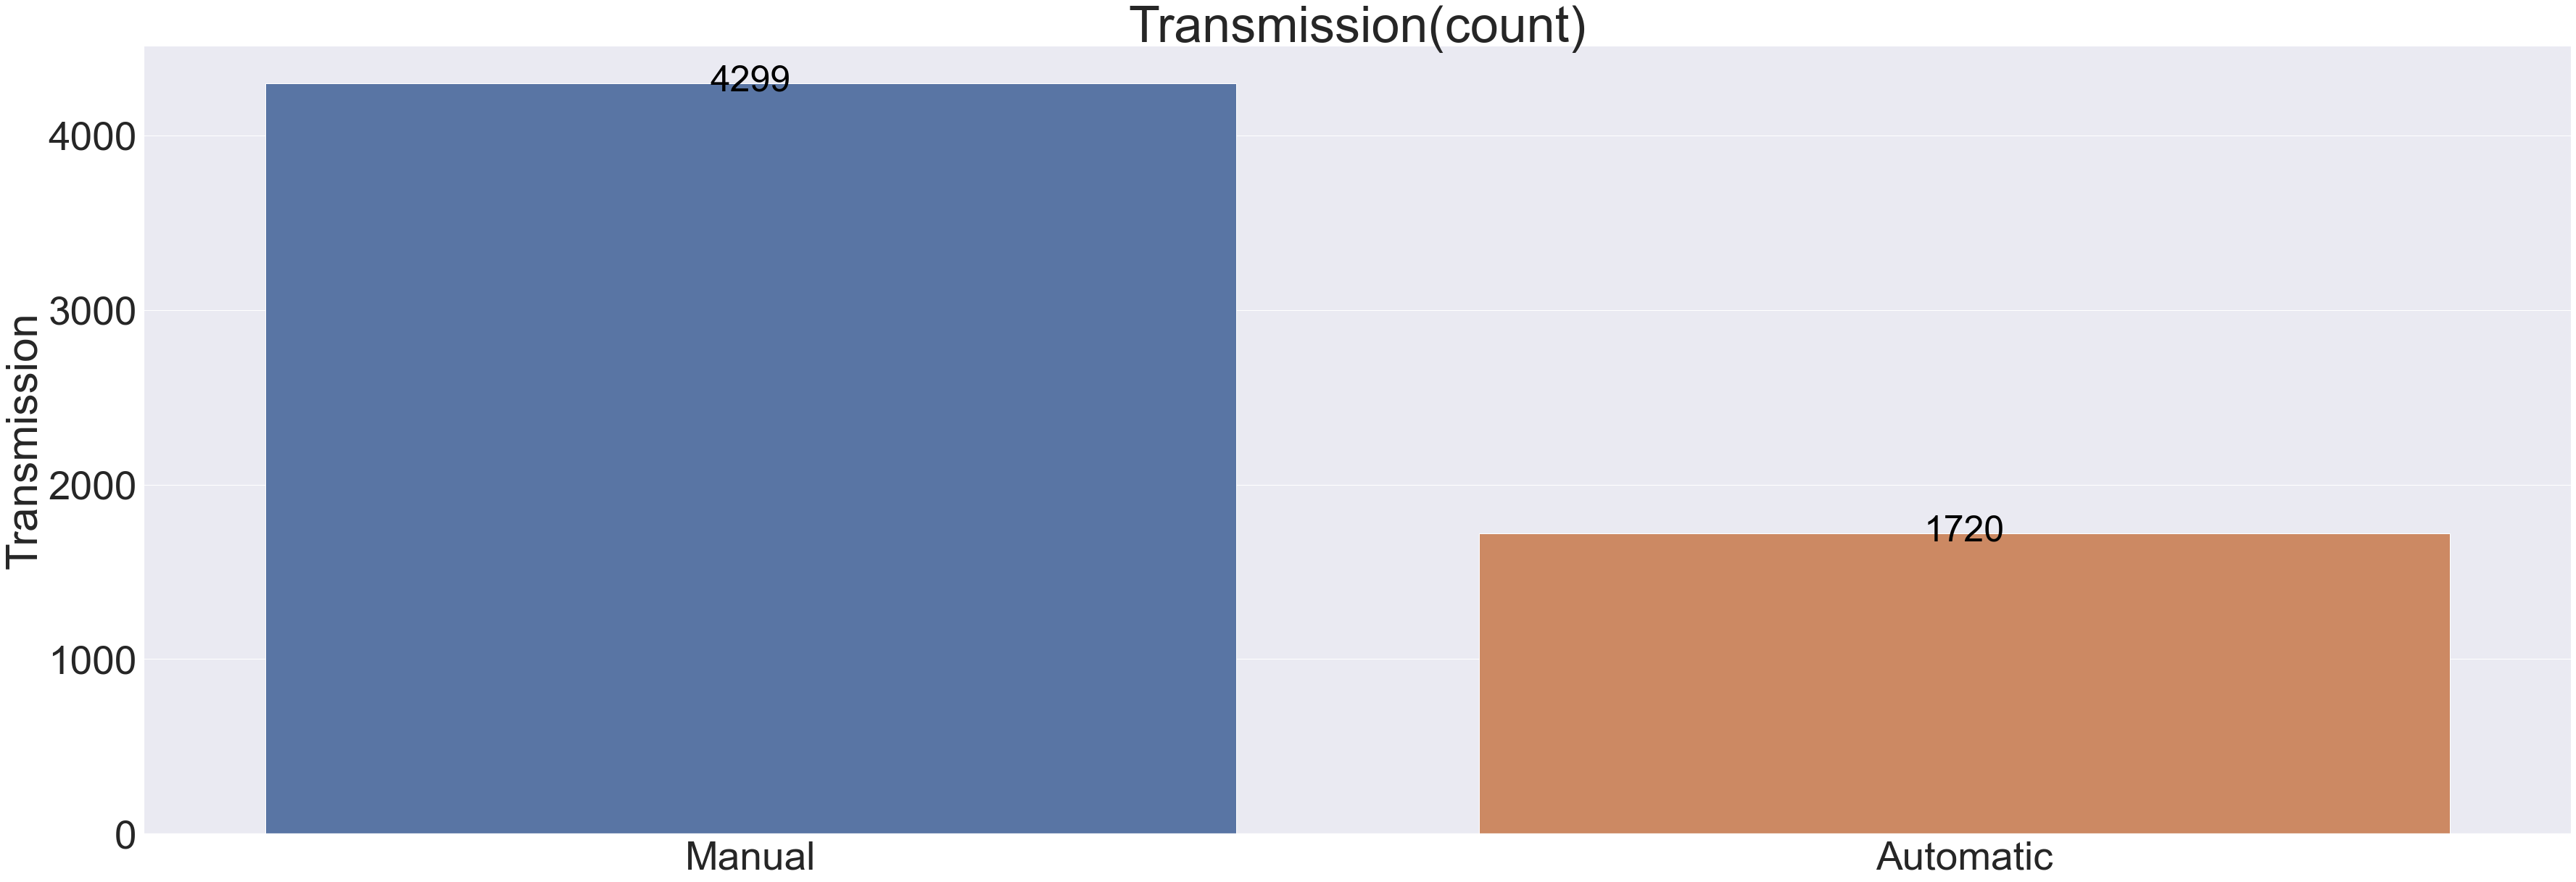

In [9]:
# Transmission
sns.set(font_scale = 5)
vc_tmp = pd.DataFrame(data['Transmission'].value_counts())
plt.figure(figsize=(60, 20), facecolor='white')
g = sns.barplot(x= vc_tmp.index, y=vc_tmp['Transmission'])
ax = g

# 각 범주별 데이터 개수 확인
for p in ax.patches: 
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width()/2., p.get_height() - 30), 
       ha='center', va='center', fontsize=50, color='black', xytext=(0, 10), 
       textcoords='offset points') 

plt.title("%s(count)"%'Transmission', fontsize=70)
plt.show()

Manual의 데이터 개수가 Automatic의 데이터 개수보다 약 3.5배 많은 것을 확인. 

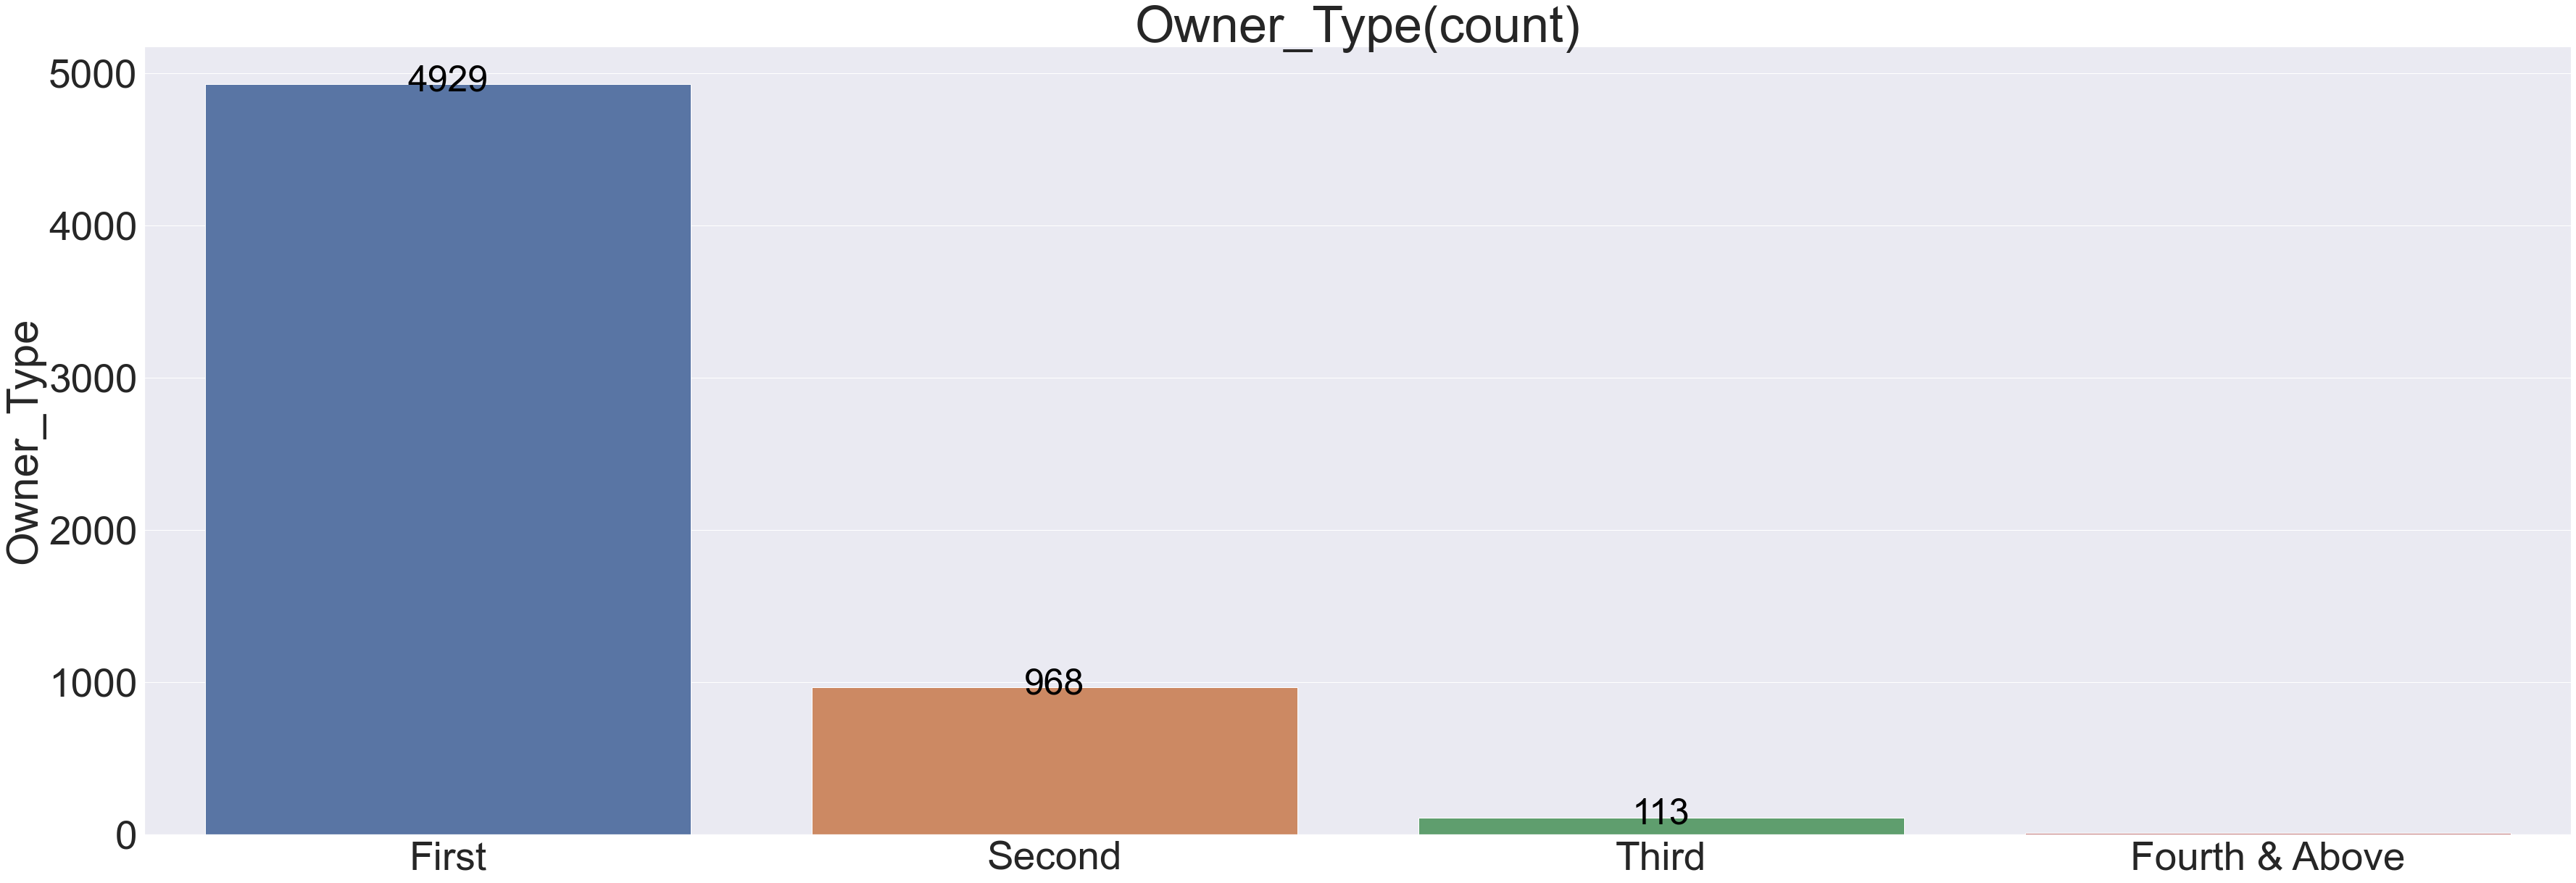

In [10]:
# Owner_Type
sns.set(font_scale = 5)
vc_tmp = pd.DataFrame(data['Owner_Type'].value_counts())
plt.figure(figsize=(60, 20), facecolor='white')
g = sns.barplot(x= vc_tmp.index, y=vc_tmp['Owner_Type'])
ax = g

# 각 범주별 데이터 개수 확인
for p in ax.patches: 
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width()/2., p.get_height() - 30), 
       ha='center', va='center', fontsize=50, color='black', xytext=(0, 10), 
       textcoords='offset points') 

plt.title("%s(count)"%'Owner_Type', fontsize=70)
plt.show()

First의 데이터 개수가 Second의 데이터 개수보다 약 5배 많은 것을 확인. 
<br>또한, Third, Fourth & Above의 데이터개수가 매우 적으므로, <br>전처리 단계에서 범주를 First, Second, etc 로 재범주화 한다.

# 전처리
1. New_Price, Name 변수 삭제
2. Mileage, Engine, Power 변수에서 단위 제거하기.
3. Engine, Power, Seats 결측치 대체하기.
4. Fuel_Type,Owner_Type 재범주화


In [11]:
# 1. New_Price, Name 변수 삭제
data.drop(['New_Price','Name'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           6019 non-null   object 
 1   Year               6019 non-null   int64  
 2   Kilometers_Driven  6019 non-null   int64  
 3   Fuel_Type          6019 non-null   object 
 4   Transmission       6019 non-null   object 
 5   Owner_Type         6019 non-null   object 
 6   Mileage            6017 non-null   object 
 7   Engine             5983 non-null   object 
 8   Power              5983 non-null   object 
 9   Seats              5977 non-null   float64
 10  Price              6019 non-null   float64
dtypes: float64(2), int64(2), object(7)
memory usage: 517.4+ KB


In [12]:
# 2. Mileage, Engine, Power 변수에서 단위 제거하기.
data['Mileage']

0       26.6 km/kg
1       19.67 kmpl
2        18.2 kmpl
3       20.77 kmpl
4        15.2 kmpl
           ...    
6014     28.4 kmpl
6015     24.4 kmpl
6016     14.0 kmpl
6017     18.9 kmpl
6018    25.44 kmpl
Name: Mileage, Length: 6019, dtype: object

In [13]:
def del_unit(column):
    str_split = data[column].str.split(" ")
    data[column] = str_split.str.get(0)

In [14]:
del_unit('Engine')
data['Engine'] = pd.to_numeric(data['Engine'])
data['Engine']

0        998.0
1       1582.0
2       1199.0
3       1248.0
4       1968.0
         ...  
6014    1248.0
6015    1120.0
6016    2498.0
6017     998.0
6018     936.0
Name: Engine, Length: 6019, dtype: float64

In [15]:
del_unit('Mileage')
data['Mileage'] = pd.to_numeric(data['Mileage'])
data['Mileage']

0       26.60
1       19.67
2       18.20
3       20.77
4       15.20
        ...  
6014    28.40
6015    24.40
6016    14.00
6017    18.90
6018    25.44
Name: Mileage, Length: 6019, dtype: float64

In [16]:
del_unit('Power')
#data['Mileage'] = pd.to_numeric(data['Mileage'])
data['Power']

0       58.16
1       126.2
2        88.7
3       88.76
4       140.8
        ...  
6014       74
6015       71
6016      112
6017     67.1
6018     57.6
Name: Power, Length: 6019, dtype: object

In [17]:
data

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,1.75
1,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.2,5.0,12.50
2,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.7,5.0,4.50
3,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00
4,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.8,5.0,17.74
...,...,...,...,...,...,...,...,...,...,...,...
6014,Delhi,2014,27365,Diesel,Manual,First,28.40,1248.0,74,5.0,4.75
6015,Jaipur,2015,100000,Diesel,Manual,First,24.40,1120.0,71,5.0,4.00
6016,Jaipur,2012,55000,Diesel,Manual,Second,14.00,2498.0,112,8.0,2.90
6017,Kolkata,2013,46000,Petrol,Manual,First,18.90,998.0,67.1,5.0,2.65


In [18]:
# 3. Engine, Power, Seats 결측치 대체하기
data['Engine'].isna().sum()

36

In [19]:
data[data['Engine'].isna()]

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
194,Ahmedabad,2007,60006,Petrol,Manual,First,0.00,NaN,NaN,NaN,2.95
208,Kolkata,2010,42001,Petrol,Manual,First,16.10,NaN,NaN,NaN,2.11
733,Chennai,2006,97800,Petrol,Manual,Third,16.10,NaN,NaN,NaN,1.75
749,Mumbai,2008,55001,Diesel,Automatic,Second,0.00,NaN,NaN,NaN,26.50
1294,Delhi,2009,55005,Petrol,Manual,First,12.80,NaN,NaN,NaN,3.20
1327,Hyderabad,2015,50295,Petrol,Manual,First,16.10,NaN,NaN,NaN,5.80
1385,Pune,2004,115000,Petrol,Manual,Second,0.00,NaN,NaN,NaN,1.50
1460,Coimbatore,2008,69078,Petrol,Manual,First,0.00,NaN,NaN,NaN,40.88
2074,Pune,2011,24255,Petrol,Manual,First,16.10,NaN,NaN,NaN,3.15
2096,Coimbatore,2004,52146,Petrol,Manual,First,0.00,NaN,NaN,NaN,1.93


In [20]:
data[data['Engine']=='null']

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price


In [21]:
data[data['Seats']=='null']

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price


In [22]:
data['Power'].isna().sum()

36

In [23]:
data[data['Power'].isna()]

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
194,Ahmedabad,2007,60006,Petrol,Manual,First,0.00,NaN,NaN,NaN,2.95
208,Kolkata,2010,42001,Petrol,Manual,First,16.10,NaN,NaN,NaN,2.11
733,Chennai,2006,97800,Petrol,Manual,Third,16.10,NaN,NaN,NaN,1.75
749,Mumbai,2008,55001,Diesel,Automatic,Second,0.00,NaN,NaN,NaN,26.50
1294,Delhi,2009,55005,Petrol,Manual,First,12.80,NaN,NaN,NaN,3.20
1327,Hyderabad,2015,50295,Petrol,Manual,First,16.10,NaN,NaN,NaN,5.80
1385,Pune,2004,115000,Petrol,Manual,Second,0.00,NaN,NaN,NaN,1.50
1460,Coimbatore,2008,69078,Petrol,Manual,First,0.00,NaN,NaN,NaN,40.88
2074,Pune,2011,24255,Petrol,Manual,First,16.10,NaN,NaN,NaN,3.15
2096,Coimbatore,2004,52146,Petrol,Manual,First,0.00,NaN,NaN,NaN,1.93


In [24]:
data['Seats'].isna().sum()

42

Engine, Power, Seats는 결측치가 같이 존재하는 경우 다수
=> 따라서 세 변수가 모두 결측치인 데이터는 제거

In [25]:
data[data['Engine'].isna()]

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
194,Ahmedabad,2007,60006,Petrol,Manual,First,0.00,NaN,NaN,NaN,2.95
208,Kolkata,2010,42001,Petrol,Manual,First,16.10,NaN,NaN,NaN,2.11
733,Chennai,2006,97800,Petrol,Manual,Third,16.10,NaN,NaN,NaN,1.75
749,Mumbai,2008,55001,Diesel,Automatic,Second,0.00,NaN,NaN,NaN,26.50
1294,Delhi,2009,55005,Petrol,Manual,First,12.80,NaN,NaN,NaN,3.20
1327,Hyderabad,2015,50295,Petrol,Manual,First,16.10,NaN,NaN,NaN,5.80
1385,Pune,2004,115000,Petrol,Manual,Second,0.00,NaN,NaN,NaN,1.50
1460,Coimbatore,2008,69078,Petrol,Manual,First,0.00,NaN,NaN,NaN,40.88
2074,Pune,2011,24255,Petrol,Manual,First,16.10,NaN,NaN,NaN,3.15
2096,Coimbatore,2004,52146,Petrol,Manual,First,0.00,NaN,NaN,NaN,1.93


In [26]:
idx = data[(data['Engine'].isna()) & (data['Power'].isna()) & (data['Seats'].isna())].index
idx

Int64Index([ 194,  208,  733,  749, 1294, 1327, 1385, 1460, 2074, 2096, 2264,
            2325, 2335, 2530, 2542, 2623, 2668, 2737, 2780, 2842, 3272, 3404,
            3520, 3522, 3810, 4011, 4152, 4229, 4577, 4604, 4697, 4712, 4952,
            5015, 5185, 5270],
           dtype='int64')

In [27]:
data.drop(idx, inplace=True)

In [28]:
print(data['Engine'].isna().sum())
print(data['Power'].isna().sum())
print(data['Seats'].isna().sum())

0
0
6


Power가 null값인 데이터 결측치 대체

In [29]:
data[data['Seats'].isna()]

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
229,Bangalore,2015,70436,Diesel,Manual,First,0.0,1498.0,99,NaN,3.60
1917,Jaipur,2005,88000,Petrol,Manual,Second,13.0,1493.0,100,NaN,1.70
2369,Chennai,2008,56000,Petrol,Manual,Second,19.5,1061.0,null,NaN,1.50
3800,Mumbai,2012,129000,Diesel,Automatic,First,12.8,2953.0,null,NaN,7.00
3882,Kolkata,2010,40000,Petrol,Manual,Second,19.5,1061.0,null,NaN,2.50
5893,Chennai,2008,51000,Petrol,Manual,Second,19.5,1061.0,null,NaN,1.75


In [30]:
data[data['Power']=='null']

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
76,Jaipur,2008,111111,Diesel,Manual,First,17.80,1399.0,null,5.0,2.00
79,Hyderabad,2005,87591,Petrol,Manual,First,0.00,1086.0,null,5.0,1.30
89,Hyderabad,2007,73745,Petrol,Manual,First,17.00,1086.0,null,5.0,2.10
120,Mumbai,2005,102000,Petrol,Manual,Second,17.00,1086.0,null,5.0,0.85
143,Kochi,2008,80759,Petrol,Manual,Third,17.00,1086.0,null,5.0,1.67
...,...,...,...,...,...,...,...,...,...,...,...
5873,Pune,2006,47200,Petrol,Manual,Second,17.00,1086.0,null,5.0,1.20
5893,Chennai,2008,51000,Petrol,Manual,Second,19.50,1061.0,null,NaN,1.75
5925,Pune,2010,85000,Petrol,Manual,First,17.50,1798.0,null,5.0,2.85
5943,Chennai,2002,75000,Diesel,Manual,First,0.00,2112.0,null,6.0,1.70


In [31]:
data[data['Power'].isnull()]

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price


Power의 값 중 'null'이 문자열로 인식되어 결측값으로 인식되지 않음. 따라서 이 데이터도 결측치 처리 해야 함.

In [32]:
data.loc[data['Power']=='null','Seats'].value_counts()

5.0     93
2.0      3
6.0      2
7.0      2
8.0      1
0.0      1
10.0     1
Name: Seats, dtype: int64

In [33]:
data.loc[data['Seats']==5,'Power'].value_counts()

74       235
73.9     125
98.6     119
78.9     111
67.1     107
        ... 
130.3      1
261.5      1
63         1
74.96      1
144        1
Name: Power, Length: 305, dtype: int64

In [34]:
data.loc[data['Power'] == 'null','Power'] = np.nan
data[data['Power']=='null']

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price


In [35]:
data['Power'].isna().sum()

107

In [36]:
data['Power'] = pd.to_numeric(data['Power'])

In [37]:
data[data['Seats']==5].mean()

Year                  2013.355006
Kilometers_Driven    56428.163143
Mileage                 18.838569
Engine                1493.747906
Power                  107.503965
Seats                    5.000000
Price                    8.478791
dtype: float64

Power가 null인 데이터의 Seats 값은 대부분 5.0의 값을 가짐<br>
=> 따라서 Power가 null인 데이터의 Seats 값을 5.0이라고 판단하고, 
그 때의 Power의 평균이 107.503965이므로 이 값으로 Power가 null인 데이터를 대체한다. 

In [38]:
data['Power'].fillna(107.503965, inplace=True)
data['Power'].isna().sum()

0

In [39]:
data.isna().sum()

Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              2
Engine               0
Power                0
Seats                6
Price                0
dtype: int64

나머지 결측치들은 제거

In [40]:
data = data[(data['Mileage'].isna()==False) & (data['Seats'].isna()==False)]

In [41]:
data.isna().sum()

Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
dtype: int64

In [42]:
data.shape

(5975, 11)

In [43]:
# 4. Fuel_Type,Owner_Type 재범주화
data['Fuel_Type'].value_counts()

Diesel    3195
Petrol    2714
CNG         56
LPG         10
Name: Fuel_Type, dtype: int64

In [44]:
data.loc[(data['Fuel_Type']=='CNG') | (data['Fuel_Type']=='LPG'),'Fuel_Type'] = 'etc'
data['Fuel_Type'].value_counts()

Diesel    3195
Petrol    2714
etc         66
Name: Fuel_Type, dtype: int64

In [45]:
data['Owner_Type'].value_counts()

First             4903
Second             953
Third              111
Fourth & Above       8
Name: Owner_Type, dtype: int64

In [46]:
data.loc[(data['Owner_Type']=='Third') | (data['Owner_Type']=='Fourth & Above'),'Owner_Type'] = 'etc'
data['Owner_Type'].value_counts()

First     4903
Second     953
etc        119
Name: Owner_Type, dtype: int64

In [47]:
# 최종 데이터
data

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Mumbai,2010,72000,etc,Manual,First,26.60,998.0,58.16,5.0,1.75
1,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50
2,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50
3,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00
4,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74
...,...,...,...,...,...,...,...,...,...,...,...
6014,Delhi,2014,27365,Diesel,Manual,First,28.40,1248.0,74.00,5.0,4.75
6015,Jaipur,2015,100000,Diesel,Manual,First,24.40,1120.0,71.00,5.0,4.00
6016,Jaipur,2012,55000,Diesel,Manual,Second,14.00,2498.0,112.00,8.0,2.90
6017,Kolkata,2013,46000,Petrol,Manual,First,18.90,998.0,67.10,5.0,2.65


In [48]:
# 원핫 인코딩
final_data = pd.get_dummies(data)
final_data

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price,Location_Ahmedabad,Location_Bangalore,Location_Chennai,...,Location_Mumbai,Location_Pune,Fuel_Type_Diesel,Fuel_Type_Petrol,Fuel_Type_etc,Transmission_Automatic,Transmission_Manual,Owner_Type_First,Owner_Type_Second,Owner_Type_etc
0,2010,72000,26.60,998.0,58.16,5.0,1.75,0,0,0,...,1,0,0,0,1,0,1,1,0,0
1,2015,41000,19.67,1582.0,126.20,5.0,12.50,0,0,0,...,0,1,1,0,0,0,1,1,0,0
2,2011,46000,18.20,1199.0,88.70,5.0,4.50,0,0,1,...,0,0,0,1,0,0,1,1,0,0
3,2012,87000,20.77,1248.0,88.76,7.0,6.00,0,0,1,...,0,0,1,0,0,0,1,1,0,0
4,2013,40670,15.20,1968.0,140.80,5.0,17.74,0,0,0,...,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6014,2014,27365,28.40,1248.0,74.00,5.0,4.75,0,0,0,...,0,0,1,0,0,0,1,1,0,0
6015,2015,100000,24.40,1120.0,71.00,5.0,4.00,0,0,0,...,0,0,1,0,0,0,1,1,0,0
6016,2012,55000,14.00,2498.0,112.00,8.0,2.90,0,0,0,...,0,0,1,0,0,0,1,0,1,0
6017,2013,46000,18.90,998.0,67.10,5.0,2.65,0,0,0,...,0,0,0,1,0,0,1,1,0,0


# train, test split

sklearn의 model_selection 패키지의 train_test_split 를 이용하여 train, test set을 분리해준다.

In [49]:
# X, y split
X = final_data.drop(["Price"], axis=1)
y = final_data.Price

In [50]:
X.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Location_Ahmedabad,Location_Bangalore,Location_Chennai,Location_Coimbatore,...,Location_Mumbai,Location_Pune,Fuel_Type_Diesel,Fuel_Type_Petrol,Fuel_Type_etc,Transmission_Automatic,Transmission_Manual,Owner_Type_First,Owner_Type_Second,Owner_Type_etc
0,2010,72000,26.60,998.0,58.16,5.0,0,0,0,0,...,1,0,0,0,1,0,1,1,0,0
1,2015,41000,19.67,1582.0,126.20,5.0,0,0,0,0,...,0,1,1,0,0,0,1,1,0,0
2,2011,46000,18.20,1199.0,88.70,5.0,0,0,1,0,...,0,0,0,1,0,0,1,1,0,0
3,2012,87000,20.77,1248.0,88.76,7.0,0,0,1,0,...,0,0,1,0,0,0,1,1,0,0
4,2013,40670,15.20,1968.0,140.80,5.0,0,0,0,1,...,0,0,1,0,0,1,0,0,1,0


In [51]:
y # 우리가 예측하고자 하는 y는 수치형 변수임. 따라서 선형 회귀 사용

0        1.75
1       12.50
2        4.50
3        6.00
4       17.74
        ...  
6014     4.75
6015     4.00
6016     2.90
6017     2.65
6018     2.50
Name: Price, Length: 5975, dtype: float64

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
# 8:2로 train, test set split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, 
                                                    shuffle=False, 
                                                    random_state=808) # random seed를 808로 고정시켜주었다.

In [54]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4780, 25)
(1195, 25)
(4780,)
(1195,)


train set의 행수는 4780, test set의 행수는 1195이다.

In [55]:
X_train.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Location_Ahmedabad,Location_Bangalore,Location_Chennai,Location_Coimbatore,...,Location_Mumbai,Location_Pune,Fuel_Type_Diesel,Fuel_Type_Petrol,Fuel_Type_etc,Transmission_Automatic,Transmission_Manual,Owner_Type_First,Owner_Type_Second,Owner_Type_etc
0,2010,72000,26.60,998.0,58.16,5.0,0,0,0,0,...,1,0,0,0,1,0,1,1,0,0
1,2015,41000,19.67,1582.0,126.20,5.0,0,0,0,0,...,0,1,1,0,0,0,1,1,0,0
2,2011,46000,18.20,1199.0,88.70,5.0,0,0,1,0,...,0,0,0,1,0,0,1,1,0,0
3,2012,87000,20.77,1248.0,88.76,7.0,0,0,1,0,...,0,0,1,0,0,0,1,1,0,0
4,2013,40670,15.20,1968.0,140.80,5.0,0,0,0,1,...,0,0,1,0,0,1,0,0,1,0


In [56]:
y_train

0        1.75
1       12.50
2        4.50
3        6.00
4       17.74
        ...  
4813    23.68
4814    15.75
4815     3.50
4816     6.99
4817    15.57
Name: Price, Length: 4780, dtype: float64

# 선형 회귀 모델

sklearn의 linear_model 패키지의 LinearRegression 와 statsmodels 패키지를 이용하여 선형회귀모델을 만든다.

1. sklearn의 LinearRegression

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

In [58]:
"""
model = LinearRegression()
model.fit(X_train, y_train) 

pred = model.predict(X_test)
"""

'\nmodel = LinearRegression()\nmodel.fit(X_train, y_train) \n\npred = model.predict(X_test)\n'

In [59]:
model = LinearRegression()

# 폴드 개수 할당
kfold = KFold(n_splits=5)

In [60]:
import numpy as np

def RMSE(true, pred):
    score = np.sqrt(np.mean(np.square(true-pred)))
    return score

In [61]:
cv_rmse = []
n_iter = 0

for train_index, test_index, in kfold.split(final_data):

    # 모델 학습
    model = model.fit(X_train, y_train)

    # 테스트셋 예측
    pred = model.predict(X_test)

    # 반복 횟수 1회 증가
    n_iter += 1

    error = RMSE(y_test, pred)
    train_size = X_train.shape[0]
    test_size = X_test.shape[0]

    print('\n{0}번째 교차 검증 RMSE : {1}, 학습 데이터 크기 : {2}, 검증 데이터 크기 : {3}'.format(n_iter, error, train_size, test_size))
    print('{0}번째 검증 세트 인덱스 : {1}'.format(n_iter, test_index))
    cv_rmse.append(error)

print('\n==> 이 방정식의 평균 RMSE는 {}입니다.'.format(np.mean(cv_rmse)))


1번째 교차 검증 RMSE : 5.755484208185816, 학습 데이터 크기 : 4780, 검증 데이터 크기 : 1195
1번째 검증 세트 인덱스 : [   0    1    2 ... 1192 1193 1194]

2번째 교차 검증 RMSE : 5.755484208185816, 학습 데이터 크기 : 4780, 검증 데이터 크기 : 1195
2번째 검증 세트 인덱스 : [1195 1196 1197 ... 2387 2388 2389]

3번째 교차 검증 RMSE : 5.755484208185816, 학습 데이터 크기 : 4780, 검증 데이터 크기 : 1195
3번째 검증 세트 인덱스 : [2390 2391 2392 ... 3582 3583 3584]

4번째 교차 검증 RMSE : 5.755484208185816, 학습 데이터 크기 : 4780, 검증 데이터 크기 : 1195
4번째 검증 세트 인덱스 : [3585 3586 3587 ... 4777 4778 4779]

5번째 교차 검증 RMSE : 5.755484208185816, 학습 데이터 크기 : 4780, 검증 데이터 크기 : 1195
5번째 검증 세트 인덱스 : [4780 4781 4782 ... 5972 5973 5974]

==> 이 방정식의 평균 RMSE는 5.755484208185816입니다.


In [63]:
from sklearn.model_selection import cross_val_score
cross_score_lr = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
r_score_lr = np.sqrt(-cross_score_lr)
print("LR score :",r_score_lr, " / LR mean score", r_score_lr.mean())

LR score : [6.24926289 6.11703037 9.02826389 5.37460199 6.75485287]  / LR mean score 6.704802401571992


In [64]:
from sklearn.metrics import r2_score
r2_score(y_test, pred)

0.7479846058074469

In [65]:
def adj_r2_score(y_true, y_pred, p=X.shape[1]):
    return 1-(1-r2_score(y_true, y_pred)) * (len(y_true)-1) / (len(y_true) - p - 1)

adj_r2_score(y_test, pred)

0.7425950550334401

sklearn 패키지의 linearregression()을 이용하여 만든 모형의 r2_score는 0.7480, adjusted r2_score는 0.7460임을 확인했다. 이는 r2_score가 독립변수를 추가하면 추가할수록 계속 증가하기 때문이다. 따라서 adjusted r2_score로 이 모형의 결정력이 0.7460이라고 판단할 수 있다. 

In [66]:
print(model.intercept_, model.coef_)

-2134.087638500562 [ 1.06219811e+00  1.07822809e-06 -1.87723441e-01  1.38676008e-03
  1.17620546e-01 -1.10992917e+00 -6.54793076e-01  1.48007174e+00
  4.79703500e-01  1.49871908e+00 -1.05098098e+00  1.44432557e+00
  2.75627286e-01 -5.45912870e-01 -1.48085518e+00 -1.30209032e+00
 -1.43814757e-01  3.38552147e-01 -1.87363987e+00  1.53508772e+00
  1.34846218e+00 -1.34846218e+00 -5.56468543e-02 -7.66069085e-01
  8.21715939e-01]


모형의 회귀계수는 위와 같다.

2. statsmodels 패키지를 사용한 선형 회귀 분석

In [67]:
import statsmodels.api as sm

In [68]:
ols_model = sm.OLS(y_train, X_train)

In [69]:
result = ols_model.fit()

In [70]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     514.6
Date:                Tue, 31 Jan 2023   Prob (F-statistic):               0.00
Time:                        14:49:35   Log-Likelihood:                -15472.
No. Observations:                4780   AIC:                         3.099e+04
Df Residuals:                    4758   BIC:                         3.113e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Year                       1

- ols 모델의 R-squared score는 0.694, Adjusted R-squared score는 0.693이었다. 하지만 R-squared score는 독립변수를 추가하면 추가할수록 계속 증가하기 때문에 사실상 평가지표로 사용하지 않고, Adjusted R-squared score 로 판단했을 때 이 모형의 정확도는 0.693이라고 말할 수 있다.
<br><br>
- 모형이 적합한지 확인하기 위해 F-test를 시행. "귀무가설 : 이 모형은 적합하지 않다. vs 대립가설 : 이 모형은 적합하다" 로 가설을 설정하였을 때, 유의수준 alpha=0.05 하에 F-test를 시행하니 F-statistic Prob은 0으로 0 < 0.05로 귀무가설을 기각하게 되므로 모형이 적합하다고 말할 수 있다.
<br><br>
- 회귀계수가 유의미한지 확인하기 위해 t-test를 시행. Pr(>|t|)값은 t검정의 p value값으로 회귀계수값이 0이냐 아니냐를 검정한다. 따라서 유의수준을 alpha=0.05로 검정했을 때, 유의수준값보다 작으면 귀무가설을 기각하므로 그 변수는 유의미하다고 볼 수 있다고 해석한다.
<br><br>
    - t검정에 의해 유의미하다고 판단되는 변수들<br>
    : Year, Mileage, Engine, Power, Seats, Location, Fuel_Type, Transmission, Owner_Type
    - t검정에 의해 유의미하지 않다고 판단되는 변수<br>
    : Kilometers_Driven
    <br><br>
- 잔차의 독립성을 확인하기 위해 Durbin-Watson test를 시행. 잔차끼리 자기상관성이 있는지 없는지를 판단하는 검증방법. Durbin-Watson 통계량 d가 2에 가까울수록 자기상관이 없다. 모형의 결과에서 d값이 2.001이므로 잔차끼리 자기상관성이 없다고 판단할 수 있다. <br>